In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import seaborn as sn
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import time
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/kaggle/input/l7-data/train.csv')
valid = pd.read_csv('/kaggle/input/l7-data/valid.csv')
test = pd.read_csv('/kaggle/input/l7-data/test.csv')

In [4]:
train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768,label_1,label_2,label_3,label_4
0,0.186257,-0.058807,0.024632,-0.163933,-0.146699,0.035889,0.111708,-0.162861,0.028249,-0.098063,...,0.055629,-0.010358,0.125754,0.011648,0.079197,0.093215,45,NaN,1,6
1,0.063431,-0.023597,0.068057,-0.252915,-0.061094,-0.027316,0.135747,-0.168147,0.091236,-0.078473,...,-0.014893,0.071721,0.018918,0.100032,-0.083042,0.088615,45,NaN,1,6
2,0.034962,0.035816,-0.029753,-0.094607,-0.017576,-0.053074,0.040121,-0.007932,0.097872,-0.024042,...,0.012415,0.015215,0.083808,0.031312,-0.056277,0.064702,45,NaN,1,6
3,0.033772,0.085612,0.067488,-0.073953,-0.180646,-0.024512,0.242879,-0.023374,-0.059999,0.002006,...,-0.078246,-0.032903,0.082949,-0.020659,0.082274,-0.050164,45,NaN,1,6
4,0.134305,0.062096,0.106920,-0.089327,0.117093,-0.077107,0.152579,0.047529,-0.015998,-0.110657,...,-0.094629,0.069718,0.014379,0.048124,0.007586,-0.016980,45,NaN,1,6


In [5]:
svm = SVC(kernel='linear')
def svm_classifier(X_train, Y_train, X_val, Y_val):
    svm.fit(X_train, Y_train)

    y_pred = svm.predict(X_val)

    accuracy = accuracy_score(Y_val, y_pred)
    return accuracy

In [6]:
knn = KNeighborsClassifier(n_neighbors=1)
def knn_classifier(X_train, Y_train, X_val, Y_val):

    knn.fit(np.array(X_train), Y_train)

    y_pred = knn.predict(np.array(X_val))

    accuracy = accuracy_score(Y_val, y_pred)
    return accuracy

In [7]:
logreg = LogisticRegression()
def logistic_regression_classifier(X_train, Y_train, X_val, Y_val):

    logreg.fit(X_train, Y_train)

    y_pred = logreg.predict(X_val)

    accuracy = accuracy_score(Y_val, y_pred)
    return accuracy

In [8]:
def id_highly_correlated_features(dataset, threshold):
    corr_matrix = dataset.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    return set(to_drop)

In [9]:
def id_weekly_correlated_features_with_label(dataset, label, threshold = 0.01):
    for label_ in train.iloc[:, -4:]:
        if label_ != label:
            dataset = dataset.drop(label_, axis=1)  # remove other targets from the dataset
    corr_matrix = dataset.corr().abs()
    weak_corr_features = corr_matrix[corr_matrix[label] < threshold].index.tolist()
    if label in weak_corr_features:
        weak_corr_features.remove(label)
    return weak_corr_features

# **Label 1**

In [10]:
label_1_train = train.copy()
label_1_valid = valid.copy()
label_1_test = test.copy()

In [11]:
label_1_train = label_1_train.dropna(subset=['label_1'])
label_1_valid = label_1_valid.dropna(subset=['label_1'])

In [12]:
label_1_test.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
0,1,0.187868,-0.009268,0.039846,-0.102515,-0.109121,-0.079769,0.061295,-0.042890,0.099860,...,0.043647,0.061174,0.026771,-0.092734,-0.052383,-0.055526,0.029101,0.041857,-0.027872,0.099500
1,2,0.122119,0.019015,0.134483,0.007949,-0.157884,-0.033332,0.044334,-0.016869,-0.014088,...,-0.179798,-0.027611,0.240023,-0.005648,-0.057537,0.023922,-0.038126,-0.015171,-0.006270,-0.003790
2,3,0.079187,0.146195,-0.001316,-0.085596,-0.261093,-0.021620,0.268898,-0.103950,0.068976,...,-0.075460,0.037346,0.124254,-0.369695,-0.056773,-0.028471,0.019971,-0.065683,-0.047366,-0.121744
3,4,0.231196,0.021558,0.215534,-0.210258,-0.158189,0.041621,0.240254,-0.068112,-0.017550,...,0.083334,0.141642,-0.007219,0.031547,-0.010762,-0.169036,-0.030963,0.086698,0.114194,-0.036775
4,5,0.020412,0.063732,-0.065506,-0.089598,-0.130788,-0.018809,0.119304,-0.057494,0.094714,...,-0.001969,-0.003025,-0.021156,-0.136993,-0.003615,0.036371,0.048715,-0.002688,-0.016957,-0.004331


In [13]:
X_train = label_1_train.iloc[:, :-4]
y_train = label_1_train.iloc[:, -4:]
X_val = label_1_valid.iloc[:, :-4]
y_val = label_1_valid.iloc[:, -4:]
X_test = label_1_test.iloc[:, 1:]

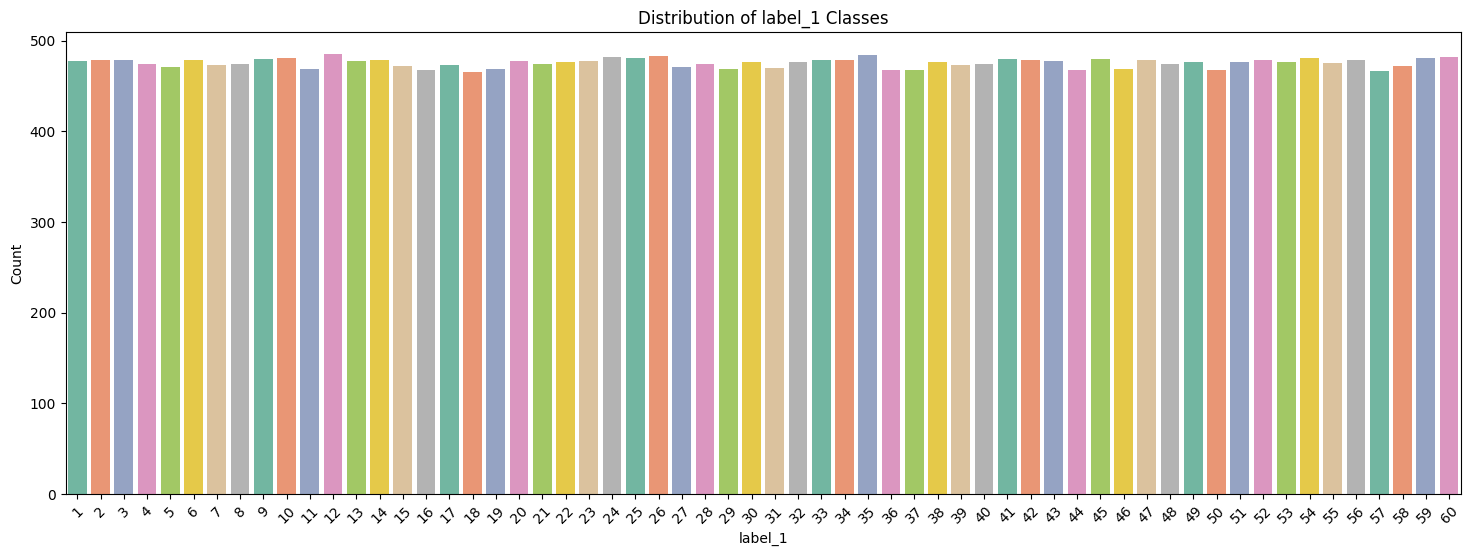

In [14]:
plt.figure(figsize=(18, 6))
sn.countplot(data=y_train, x='label_1', palette='Set2')
plt.title('Distribution of label_1 Classes')
plt.xlabel('label_1')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [15]:
# accuracy with all the features
#svm
start_time = time.time()
accuracy = svm_classifier(X_train, y_train['label_1'], X_val, y_val['label_1'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

Accuracy: 97.47% in 53.298977851867676 secs


In [16]:
# accuracy with all the features
#knn
start_time = time.time()
accuracy = knn_classifier(X_train, y_train['label_1'], X_val, y_val['label_1'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

Accuracy: 94.40% in 0.9723339080810547 secs


In [17]:
# accuracy with all the features
#logistic_regression_classifier
start_time = time.time()
accuracy = logistic_regression_classifier(X_train, y_train['label_1'], X_val, y_val['label_1'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

Accuracy: 97.20% in 38.71573185920715 secs


In [18]:
label_1_pred_before = svm.predict(np.array(X_test))

In [19]:
weekly_related_features = id_weekly_correlated_features_with_label(X_train_pca, 'label_1',0.01)
len(set(weekly_related_features))

NameError: name 'X_train_pca' is not defined

In [ ]:
print(f"dropping weekly related features count {len(set(weekly_related_features))}")
X_train_filtered = X_train.drop(columns=list(weekly_related_features))
X_val_filtered = X_val.drop(columns=list(weekly_related_features))
X_test_filtered = X_test.drop(columns=list(weekly_related_features))
start_time = time.time()
accuracy = svm_classifier(X_train_filtered, y_train['label_1'], X_val_filtered, y_val['label_1'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
highly_related_features = id_highly_correlated_features(X_train_filtered, 0.5)
len(set(highly_related_features))

In [ ]:
print(f"dropping highly related features count {len(set(highly_related_features))}")
X_train_filtered = X_train_filtered.drop(columns=list(highly_related_features))
X_val_filtered = X_val_filtered.drop(columns=list(highly_related_features))
X_test_filtered = X_test_filtered.drop(columns=list(highly_related_features))
start_time = time.time()
accuracy = svm_classifier(X_train_filtered, y_train['label_1'], X_val_filtered, y_val['label_1'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_val_scaled = scaler.transform(X_val_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

In [ ]:
start_time = time.time()
accuracy = svm_classifier(X_train_scaled, y_train['label_1'], X_val_scaled, y_val['label_1'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
X_train_scaled.shape

In [ ]:
pca = PCA(n_components=0.95, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [ ]:
start_time = time.time()
accuracy = svm_classifier(X_train_pca, y_train['label_1'], X_val_pca, y_val['label_1'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
X_train_pca.shape

In [ ]:
# # Hyper Parameter Tuning For SVC

# from sklearn.model_selection import GridSearchCV
  
# # defining parameter range
# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']} 
  
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# # fitting the model for grid search
# grid.fit(X_train_pca, y_train['label_1'])
# grid.best_params_

In [ ]:
# grid.best_estimator_

In [ ]:
cross_val_score(SVC(C=1000, gamma=0.001, kernel='rbf'), X_train_pca, y_train['label_1'], cv=3).mean()

In [ ]:
best_model_label_1 = SVC(C=1000, gamma=0.001, kernel='rbf', probability=True)
best_model_label_1.fit(X_train_pca, y_train['label_1'])
pred = best_model_label_1.predict(X_val_pca)
accuracy_score(y_val['label_1'], pred )

In [ ]:
label_1_pred_after = best_model_label_1.predict(np.array(X_test_pca))

Label 2

In [ ]:
label_2_train = train.copy()
label_2_valid = valid.copy()
label_2_test = test.copy()
label_2_test.head()

In [ ]:
label_2_train = label_2_train.dropna(subset=['label_2'])
label_2_valid = label_2_valid.dropna(subset=['label_2'])

In [ ]:
X_train = label_2_train.iloc[:, :-4]
y_train = label_2_train.iloc[:, -3:]
X_val = label_2_valid.iloc[:, :-4]
y_val = label_2_valid.iloc[:, -3:]
X_test = label_2_test.iloc[:, 1:]

In [ ]:
X_test.head()

In [ ]:
plt.figure(figsize=(18, 6))
sn.histplot(data=y_train, x='label_2', bins=20, kde=False)

In [ ]:
# accuracy with all the features
#svm
start_time = time.time()
accuracy = svm_classifier(X_train, y_train['label_2'], X_val, y_val['label_2'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
# accuracy with all the features
#knn
start_time = time.time()
accuracy = knn_classifier(X_train, y_train['label_2'], X_val, y_val['label_2'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
# accuracy with all the features
#logistic_regression_classifier
start_time = time.time()
accuracy = logistic_regression_classifier(X_train, y_train['label_2'], X_val, y_val['label_2'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
label_2_pred_before = svm.predict(np.array(X_test))

In [ ]:
weekly_related_features = id_weekly_correlated_features_with_label(label_2_train, 'label_2')
print(f"dropping features count {len(set(weekly_related_features))}")

In [ ]:
X_train_filtered = X_train.drop(columns=list(weekly_related_features))
X_val_filtered = X_val.drop(columns=list(weekly_related_features))
X_test_filtered = X_test.drop(columns=list(weekly_related_features))
start_time = time.time()
accuracy = svm_classifier(X_train_filtered, y_train['label_2'], X_val_filtered, y_val['label_2'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
highly_related_features = id_highly_correlated_features(X_train_filtered, 0.5)
print(f"dropping features count {len(set(highly_related_features))}")

In [ ]:
X_train_filtered = X_train_filtered.drop(columns=list(highly_related_features))
X_val_filtered = X_val_filtered.drop(columns=list(highly_related_features))
X_test_filtered = X_test_filtered.drop(columns=list(highly_related_features))
start_time = time.time()
accuracy = svm_classifier(X_train_filtered, y_train['label_2'], X_val_filtered, y_val['label_2'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_val_scaled = scaler.transform(X_val_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

In [ ]:
start_time = time.time()
accuracy = svm_classifier(X_train_scaled, y_train['label_2'], X_val_scaled, y_val['label_2'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
X_train_scaled.shape

In [ ]:
pca = PCA(n_components=0.95, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
start_time = time.time()
accuracy = svm_classifier(X_train_pca, y_train['label_2'], X_val_pca, y_val['label_2'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
X_train_pca.shape

In [ ]:
X_test_pca.shape

In [ ]:
# from sklearn.model_selection import GridSearchCV
  
# # defining parameter range
# param_grid = {'C': [1000, 1200, 1300, 1500, 1600, 2000, 1800, 2200],
#               'kernel': ['rbf']} 
  
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# # fitting the model for grid search
# grid.fit(X_train_pca, y_train['label_2'])
# grid.best_params_

In [ ]:
cross_val_score(SVC(C=1000, kernel='rbf'), X_train_pca, y_train['label_2'], cv=5).mean()

In [ ]:
best_model_label_2 = SVC(C=1000, kernel='rbf')
best_model_label_2.fit(X_train_pca, y_train['label_2'])
pred = best_model_label_2.predict(X_val_pca)
accuracy_score(y_val['label_2'], pred )

In [ ]:
label_2_pred_after = best_model_label_2.predict(np.array(X_test_pca))

Label 3

In [ ]:
label_3_train = train.copy()
label_3_valid = valid.copy()
label_3_test = test.copy()

In [ ]:
label_3_train = label_3_train.dropna(subset=['label_3'])
label_3_valid = label_3_valid.dropna(subset=['label_3'])

In [ ]:
X_train = label_3_train.iloc[:, :-4]
y_train = label_3_train.iloc[:, -2:]
X_val = label_3_valid.iloc[:, :-4]
y_val = label_3_valid.iloc[:, -2:]
X_test = label_3_test.iloc[:, 1:]

In [ ]:
plt.figure(figsize=(18, 6))
sn.histplot(data=y_train, x='label_3', bins=20, kde=False)

In [ ]:
ros = RandomOverSampler(random_state=0, sampling_strategy=0.75)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train['label_3'])

In [ ]:
y_train_resampled

In [ ]:
ax = sn.countplot(x=y_train['label_3'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

In [ ]:
# accuracy with all the features
#svm
start_time = time.time()
accuracy = svm_classifier(X_train_resampled, y_train_resampled, X_val, y_val['label_3'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
# accuracy with all the features
#knn
start_time = time.time()
accuracy = knn_classifier(X_train_resampled, y_train_resampled, X_val, y_val['label_3'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
# accuracy with all the features
#logistic_regression_classifier
start_time = time.time()
accuracy = logistic_regression_classifier(X_train_resampled, y_train_resampled, X_val, y_val['label_3'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
label_3_pred_before = svm.predict(np.array(X_test))

In [ ]:
weekly_related_features = id_weekly_correlated_features_with_label(label_3_train, 'label_3',0.03)
print(f"dropping features count {len(set(weekly_related_features))}")

In [ ]:
X_train_filtered = X_train_resampled.drop(columns=list(weekly_related_features))
X_val_filtered = X_val.drop(columns=list(weekly_related_features))
X_test_filtered = X_test.drop(columns=list(weekly_related_features))
start_time = time.time()
accuracy = svm_classifier(X_train_filtered, y_train_resampled, X_val_filtered, y_val['label_3'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
highly_related_features = id_highly_correlated_features(X_train_filtered, 0.5)
print(f"dropping features count {len(set(highly_related_features))}")

In [ ]:
X_train_filtered = X_train_filtered.drop(columns=list(highly_related_features))
X_val_filtered = X_val_filtered.drop(columns=list(highly_related_features))
X_test_filtered = X_test_filtered.drop(columns=list(highly_related_features))
start_time = time.time()
accuracy = svm_classifier(X_train_filtered, y_train_resampled, X_val_filtered, y_val['label_3'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_val_scaled = scaler.transform(X_val_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

In [ ]:
X_train_scaled.shape

In [ ]:
start_time = time.time()
accuracy = svm_classifier(X_train_scaled, y_train_resampled, X_val_scaled, y_val['label_3'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
pca = PCA(n_components=0.95, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
start_time = time.time()
accuracy = svm_classifier(X_train_pca, y_train_resampled, X_val_pca, y_val['label_3'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
cross_val_score(SVC(), X_train_pca, y_train['label_3'], cv=5).mean()

In [ ]:
best_model_label_3 = SVC()
label_3_pred_after = best_model_label_3.fit(X_train_pca, y_train['label_3']).predict(np.array(X_test_pca))

Label 4

In [ ]:
label_4_train = train.copy()
label_4_valid = valid.copy()
label_4_test = test.copy()

In [ ]:
label_4_train = label_4_train.dropna(subset=['label_4'])
label_4_valid = label_4_valid.dropna(subset=['label_4'])

In [ ]:
X_train = label_4_train.iloc[:, :-4]
y_train = label_4_train.iloc[:, -1:]
X_val = label_4_valid.iloc[:, :-4]
y_val = label_4_valid.iloc[:, -1:]
X_test = label_4_test.iloc[:, 1:]

In [ ]:
plt.figure(figsize=(18, 6))
sn.histplot(data=y_train, x='label_4', bins=20, kde=False)

In [ ]:
plt.figure(figsize=(18, 6))
ax = sn.countplot(x=y_train['label_4'], color='teal')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

In [ ]:
# accuracy with all the features
#knn
start_time = time.time()
accuracy = knn_classifier(X_train, y_train, X_val, y_val['label_4'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
label_4_pred_before = knn.predict(np.array(X_test))

In [ ]:
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train['label_4'])

In [ ]:
plt.figure(figsize=(18, 6))
ax = sn.countplot(x=y_train_resampled, color='teal')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

In [ ]:
# accuracy with all the features
#svm
start_time = time.time()
accuracy = svm_classifier(X_train_resampled, y_train_resampled, X_val, y_val['label_4'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
# accuracy with all the features
#knn
start_time = time.time()
accuracy = knn_classifier(X_train_resampled, y_train_resampled, X_val, y_val['label_4'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
# accuracy with all the features
#logistic_regression_classifier
start_time = time.time()
accuracy = logistic_regression_classifier(X_train_resampled, y_train_resampled, X_val, y_val['label_4'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
label_4_pred_before = svm.predict(np.array(X_test))

In [ ]:
weekly_related_features = id_weekly_correlated_features_with_label(label_4_train, 'label_4', 0.01)
print(f"dropping features count {len(set(weekly_related_features))}")

In [ ]:
X_train_filtered = X_train_resampled.drop(columns=list(weekly_related_features))
X_val_filtered = X_val.drop(columns=list(weekly_related_features))
X_test_filtered = X_test.drop(columns=list(weekly_related_features))
start_time = time.time()
accuracy = svm_classifier(X_train_filtered, y_train_resampled, X_val_filtered, y_val['label_4'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
highly_related_features = id_highly_correlated_features(X_train_filtered, 0.5)
print(f"dropping features count {len(set(highly_related_features))}")

In [ ]:
X_train_filtered = X_train_filtered.drop(columns=list(highly_related_features))
X_val_filtered = X_val_filtered.drop(columns=list(highly_related_features))
X_test_filtered = X_test_filtered.drop(columns=list(highly_related_features))
start_time = time.time()
accuracy = svm_classifier(X_train_filtered, y_train_resampled, X_val_filtered, y_val['label_4'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_val_scaled = scaler.transform(X_val_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

In [ ]:
X_train_scaled.shape

In [ ]:
start_time = time.time()
accuracy = svm_classifier(X_train_filtered, y_train_resampled, X_val_filtered, y_val['label_4'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
pca = PCA(n_components=0.95, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
X_train_pca.shape

In [ ]:
start_time = time.time()
accuracy = svm_classifier(X_train_pca, y_train_resampled, X_val_pca, y_val['label_4'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

In [ ]:
# from sklearn.model_selection import GridSearchCV
  
# # defining parameter range
# param_grid = {'C': [1000, 1200, 1300, 1500, 1600, 2000, 1800, 2200],
#               'class_weight': ['balanced', None]} 
  
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# # fitting the model for grid search
# grid.fit(X_train_pca, y_train['label_2'])
# grid.best_params_

In [ ]:
cross_val_score(SVC(class_weight='balanced', C=1000), X_train_pca, y_train['label_4'], cv=5, scoring='accuracy').mean()

In [ ]:
best_model_label_4 = SVC(class_weight='balanced', C=1000)

label_4_pred_after = best_model_label_4.fit(X_train_pca, y_train['label_4']).predict(X_test_pca)

Kaggle competition output

In [ ]:
output_df = test[['ID']]
output_df['label_1'] = label_1_pred_after
output_df['label_2'] = label_2_pred_after
output_df['label_3'] = label_3_pred_after
output_df['label_4'] = label_4_pred_after

In [ ]:
output_df.head()

In [ ]:
# Write DataFrame to CSV
output_df.to_csv('predictions_L7.csv', index=False)